In [158]:
!pip install pywavelets

### Import Required Libraries:

In [159]:
import pandas as pd
import numpy as np
from array import *
from scipy.signal import butter, filtfilt , find_peaks  , ellip
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import pywt

### Load the data

In [160]:
# Load the data from CSV file
data = pd.read_csv('filtered_output.csv')

### Process the Data

In [161]:
data.head()
# Calculate time range
if len(data) > 1:
    first_relative_time = data.loc[0, "relative_time_seconds"]
    last_relative_time = data.loc[len(data) - 1, "relative_time_seconds"]
    time_range = last_relative_time - first_relative_time
    print(f"Time range of filtered data: {time_range} seconds")
data.loc[:,"CSI_DATA"]
index = list(range(0,len(data)-1))

AmpCSI=np.zeros((len(data),64))
PhaseCSI=np.zeros((len(data),64))


for i in index:
  parts = data.loc[:,"CSI_DATA"][i].split(' ')
  # rawCSI=[s.strip('[') for s in parts]
  rawCSI=[s.strip('[') for s in parts]
  rawCSI=[s.strip(']') for s in rawCSI]
  #rawCSI.pop()

  ImCSI=np.array(rawCSI[::2],dtype=np.int64)
  ReCSI=np.array(rawCSI[1::2],dtype=np.int64)
  AmpCSI[i][:]=np.sqrt(np.power(ImCSI[:],2) + np.power(ReCSI[:],2))

  PhaseCSI[i][:]= np.arctan2(ImCSI[:], ReCSI[:])

Amp=np.concatenate((AmpCSI[:,6:32], AmpCSI[:,33:59]), axis=1)
Pha=np.concatenate((PhaseCSI[:,6:32], PhaseCSI[:,33:59]), axis=1)
csi_data = Amp

Time range of filtered data: 118.479608 seconds


### Remove DC Offset

In [162]:
# Remove the DC offset by subtracting the mean
signal_dc_removed = csi_data - np.mean(csi_data , axis=0)
print(signal_dc_removed.shape)

(11076, 52)


### Smoothing (Moving Average Filter):

In [163]:
# def moving_average(data, window_size):
#     return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

# # Example: Apply moving average to each column
# smoothed_signal = np.apply_along_axis(moving_average, 0, signal_dc_removed, window_size=5)

def smooth(a,WSZ):
    # a: NumPy 1-D array containing the data to be smoothed
    # WSZ: smoothing window size needs, which must be odd number,
    # as in the original MATLAB implementation
    out0 = np.convolve(a,np.ones(WSZ,dtype=int),'valid')/WSZ
    r = np.arange(1,WSZ-1,2)
    start = np.cumsum(a[:WSZ-1])[::2]/r
    stop = (np.cumsum(a[:-WSZ:-1])[::2]/r)[::-1]
    return np.concatenate((  start , out0, stop  ))
def movingAverage(signal, window):
    """
    Apply a moving average filter to each column of a 2D signal array.

    Parameters:
    - signal: 2D numpy array where each column represents a separate signal to smooth.
    - window: Size of the moving average window.

    Returns:
    - smoothed_signal: 2D numpy array of the same shape as the input signal.
    """
    # Initialize a 12006 x 52 array filled with zeros
    C2 = np.zeros((signal.shape[0],signal.shape[1] ))
    # Apply moving average to each column
    for i in range(signal.shape[1]):
      C2[:, i] = smooth(signal[:, i], window)

    # Optionally replace NaNs introduced by centering with 0 or other method
    # smoothed_signal = np.nan_to_num(smoothed_signal)

    return C2

# Apply moving average to each column
# smoothed_signal = movingAverage(signal_dc_removed, window=5)  # digital twin
smoothed_signal = movingAverage(signal_dc_removed, window=11) # for our data set

### Bandpass Filtering (Wavelet):

#### Heart Rate

In [164]:
def wavelet_bandpass_filter(data, sampling_rate, lowcut, highcut, wavelet='sym5'):
    """
    Applies a wavelet-based bandpass filter to keep only the coefficients within the specified frequency range.

    Parameters:
        data (array-like): Input signal (e.g., CSI amplitude or phase data).
        sampling_rate (float): Sampling frequency of the input signal (Hz).
        lowcut (float): Lower bound of the desired frequency range (Hz).
        highcut (float): Upper bound of the desired frequency range (Hz).
        wavelet (str): Type of wavelet to use (default is 'db4').

    Returns:
        np.ndarray: Filtered signal with coefficients within the specified frequency range.
    """
    # Compute the maximum decomposition level
    max_level = pywt.dwt_max_level(len(data), pywt.Wavelet(wavelet))

    # Calculate frequency ranges for each level
    nyquist = 0.5 * sampling_rate
    level_frequencies = [(nyquist / (2 ** (i + 1)), nyquist / (2 ** i)) for i in range(max_level)]

    # print("Decomposition Levels and Frequency Ranges:")
    # for i, (low, high) in enumerate(level_frequencies):
    #     print(f"Level {i + 1}: {low:.2f} Hz - {high:.2f} Hz")

    # Determine the suitable levels
    target_levels = [
        i + 1 for i, (low, high) in enumerate(level_frequencies)
        if high >= lowcut and low <= highcut
    ]
    target_levels=[ 2, 3 , 4 , 5]
    if not target_levels:
        raise ValueError(f"No suitable levels found for lowcut: {lowcut}, highcut: {highcut}")

    # Decompose the signal
    coeffs = pywt.wavedec(data, wavelet, level=max_level)

    # Zero out coefficients outside the desired frequency range
    filtered_coeffs = []
    for i, coeff in enumerate(coeffs):
        if i in target_levels:
            filtered_coeffs.append(coeff)
        else:
            filtered_coeffs.append(np.zeros_like(coeff))

    # Reconstruct the signal
    filtered_signal = pywt.waverec(filtered_coeffs, wavelet)

    # Ensure the reconstructed signal matches the original signal length
    return filtered_signal[:len(data)]
# Example parameters for the wavelet filter
fs = signal_dc_removed.shape[0] / time_range  # Sampling frequency
lowcut = 0.1  # Lower cutoff frequency in Hz
highcut = 0.5  # Upper cutoff frequency in Hz

# Apply the filter along the specified axis to get the filtered signal
filtered_signal_wavelet = np.apply_along_axis(wavelet_bandpass_filter, 0, smoothed_signal, fs, lowcut, highcut)

print("Filtered signal shape:", filtered_signal_wavelet.shape)
# High-pass filter for baseline correction
def highpass_filter(data, cutoff, fs, order=4):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='high', analog=False)
    return b, a

b,a  = highpass_filter(data, cutoff=1, fs=fs)
# Apply the filter to each channel in the signal
for i in range(filtered_signal_wavelet.shape[1]):
    # Use filtfilt to apply zero-phase filtering to avoid phase distortion
    filtered_signal_wavelet[:, i] = filtfilt(b, a, filtered_signal_wavelet[:, i])

Filtered signal shape: (11076, 52)


#### Respiration Rate

In [189]:
def wavelet_bandpass_filter(data, sampling_rate, lowcut, highcut, wavelet='sym5'):
    """
    Applies a wavelet-based bandpass filter to keep only the coefficients within the specified frequency range.

    Parameters:
        data (array-like): Input signal (e.g., CSI amplitude or phase data).
        sampling_rate (float): Sampling frequency of the input signal (Hz).
        lowcut (float): Lower bound of the desired frequency range (Hz).
        highcut (float): Upper bound of the desired frequency range (Hz).
        wavelet (str): Type of wavelet to use (default is 'db4').

    Returns:
        np.ndarray: Filtered signal with coefficients within the specified frequency range.
    """
    # Compute the maximum decomposition level
    max_level = pywt.dwt_max_level(len(data), pywt.Wavelet(wavelet))

    # Calculate frequency ranges for each level
    nyquist = 0.5 * sampling_rate
    level_frequencies = [(nyquist / (2 ** (i + 1)), nyquist / (2 ** i)) for i in range(max_level)]

    # print("Decomposition Levels and Frequency Ranges:")
    # for i, (low, high) in enumerate(level_frequencies):
    #     print(f"Level {i + 1}: {low:.2f} Hz - {high:.2f} Hz")

    # Determine the suitable levels
    target_levels = [
        i + 1 for i, (low, high) in enumerate(level_frequencies)
        if high >= lowcut and low <= highcut
    ]
    target_levels=[  2, 3]
    if not target_levels:
        raise ValueError(f"No suitable levels found for lowcut: {lowcut}, highcut: {highcut}")

    # Decompose the signal
    coeffs = pywt.wavedec(data, wavelet, level=max_level)

    # Zero out coefficients outside the desired frequency range
    filtered_coeffs = []
    for i, coeff in enumerate(coeffs):
        if i in target_levels:
            filtered_coeffs.append(coeff)
        else:
            filtered_coeffs.append(np.zeros_like(coeff))

    # Reconstruct the signal
    filtered_signal = pywt.waverec(filtered_coeffs, wavelet)

    # Ensure the reconstructed signal matches the original signal length
    return filtered_signal[:len(data)]
# Example parameters for the wavelet filter
fs = signal_dc_removed.shape[0] / time_range  # Sampling frequency
lowcut = 0.1  # Lower cutoff frequency in Hz
highcut = 0.5  # Upper cutoff frequency in Hz

# Apply the filter along the specified axis to get the filtered signal
filtered_signal_wavelet_pre = np.apply_along_axis(wavelet_bandpass_filter, 0, smoothed_signal, fs, lowcut, highcut)

print("Filtered signal shape:", filtered_signal_wavelet.shape)
# High-pass filter for baseline correction
def highpass_filter(data, cutoff, fs, order=4):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='high', analog=False)
    return b, a

b,a  = highpass_filter(data, cutoff=0.17, fs=fs)
filtered_signal_wavelet = np.zeros_like(filtered_signal_wavelet_pre)
# Apply the filter to each channel in the signal
for i in range(filtered_signal_wavelet_pre.shape[1]):
    # Use filtfilt to apply zero-phase filtering to avoid phase distortion
    filtered_signal_wavelet[:, i] = filtfilt(b, a, filtered_signal_wavelet_pre[:, i])

Filtered signal shape: (11076, 52)


### Bandpass Filtering (Butterwoth):

In [166]:
def bandpass_filter(lowcut, highcut, fs, order=4):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order,[low, high], btype='band')
    return b,a

# Parameters for the bandpass filter
fs = 100        # Sampling frequency
fs = signal_dc_removed.shape[0]/time_range
lowcut=1.5
highcut = 2.1

#### Heart rate

In [167]:
# Design the filter
b, a = bandpass_filter( lowcut, highcut, fs, order=4)

# Apply the filter to each channel in the signal
filtered_signal_butterworth = np.zeros_like(smoothed_signal)
for i in range(smoothed_signal.shape[1]):
    # Use filtfilt to apply zero-phase filtering to avoid phase distortion
    filtered_signal_butterworth[:, i] = filtfilt(b, a, smoothed_signal[:, i])


#### Respiration Rate

In [168]:
# Parameters for the bandpass filter
fs = 100        # Sampling frequency
fs = signal_dc_removed.shape[0]/time_range
# lowcut = 0.1
lowcut=0.2
highcut = 0.6
highcut = 0.75

# Design the filter
b, a = bandpass_filter( lowcut, highcut, fs, order=4)

# Apply the filter to each channel in the signal
filtered_signal_butterworth = np.zeros_like(smoothed_signal)
for i in range(smoothed_signal.shape[1]):
    # Use filtfilt to apply zero-phase filtering to avoid phase distortion
    filtered_signal_butterworth[:, i] = filtfilt(b, a, smoothed_signal[:, i])


### Bandpass Filtering(Elliptic)


In [169]:
# Design the bandpass filter using an elliptic filter
def ellip_bandpass(lowcut, highcut, fs, order=4, rp=1, rs=40):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    # Elliptic filter design
    b, a = ellip(order, rp, rs, [low, high], btype='band')
    return b, a

#### Heart rate

In [170]:
# Parameters for the bandpass filter
fs = 100        # Sampling frequency
fs = signal_dc_removed.shape[0]/time_range
# print(fs)
lowcut = 1.5
highcut = 2.1
order = 4       # Filter order

# Design the filter
b, a = ellip_bandpass(lowcut, highcut, fs, order)

# Apply the filter to each channel in the signal
filtered_signal_ellip = np.zeros_like(smoothed_signal)
for i in range(smoothed_signal.shape[1]):
    # Use filtfilt to apply zero-phase filtering to avoid phase distortion
    filtered_signal_ellip[:, i] = filtfilt(b, a, smoothed_signal[:, i])

#### Respiration Rate

In [186]:
# Parameters for the bandpass filter
fs = signal_dc_removed.shape[0]/time_range
# print(fs)
lowcut = 0.1    # Lower cutoff frequency for digital twin
lowcut = 0.2   #0.2 for out data
highcut = 0.6   # Upper cutoff frequency for digital twin
highcut = 0.75    #0.75 for out data
order = 4       # Filter order

# Design the filter
b, a = ellip_bandpass(lowcut, highcut, fs, order)

# Apply the filter to each channel in the signal
filtered_signal_ellip = np.zeros_like(smoothed_signal)
for i in range(smoothed_signal.shape[1]):
    # Use filtfilt to apply zero-phase filtering to avoid phase distortion
    filtered_signal_ellip[:, i] = filtfilt(b, a, smoothed_signal[:, i])

# PCA

In [190]:
# Apply PCA to the filtered signal
pca = PCA()
pca.fit(filtered_signal_wavelet)
pca_components = pca.transform(filtered_signal_wavelet)

# Variance explained by each principal component
explained_variance = pca.explained_variance_

# Extract the first principal component
first_pc = pca_components[:, 0]
print(first_pc)

[-0.23581787 -0.22919376 -0.2220298  ... -2.82094732 -2.67934862
 -2.52717275]


### Power Spectral Density (PSD) Calculation:

In [191]:
from scipy.signal import welch

def estimate_rr(data, fs=100):
    freqs, psd = welch(data, fs=fs, nperseg=len(data))

    freqs_symmetric = np.concatenate((-freqs[::-1], freqs))
    psd_symmetric = np.concatenate((psd[::-1], psd))

    # Identify the frequency with the highest PSD within the range
    peak_freq = freqs[np.argmax(psd)]

    # Convert peak frequency to breaths per minute
    rr_bpm = peak_freq * 60

    return rr_bpm, psd_symmetric, freqs_symmetric

# Example usage:
bpm, psd_in_range, freqs_in_range = estimate_rr(first_pc, fs=fs)
print("respiration rate: ", bpm)


respiration rate:  16.711736588460017


### Visualisation

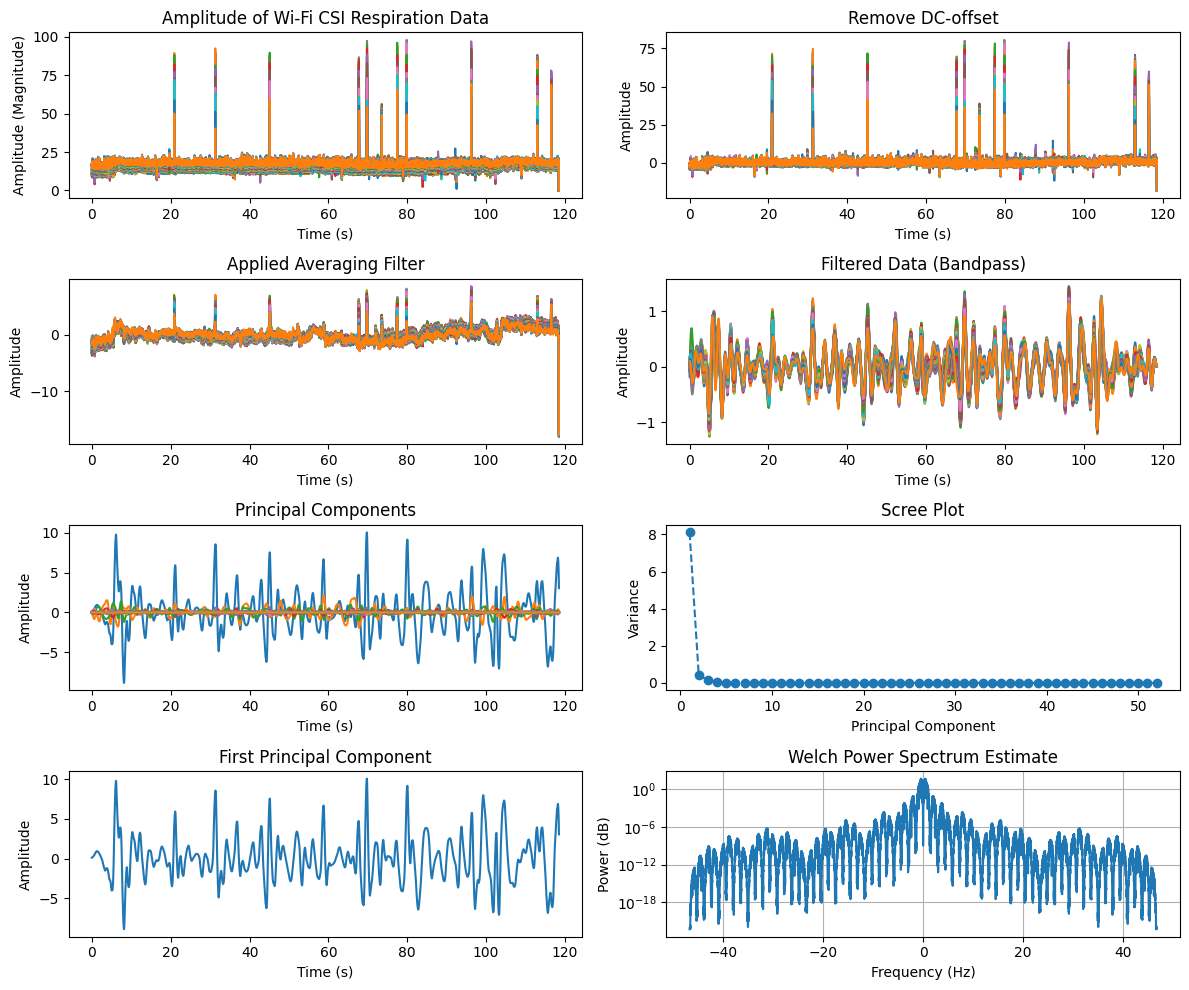

In [174]:
# Create a time array for x-axis in seconds
time = np.arange(csi_data.shape[0]) / fs

# Plotting
plt.figure(figsize=(12, 10))


# Plot the amplitude over time
plt.subplot(4, 2, 1)
plt.plot(time, csi_data)
plt.title('Amplitude of Wi-Fi CSI Respiration Data')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (Magnitude)')


# 2. Remove DC-offset
plt.subplot(4, 2, 2)
plt.plot(time, signal_dc_removed)
plt.title('Remove DC-offset')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

# 3. Applied Averaging Filter
plt.subplot(4, 2, 3)
plt.plot(time[:len(smoothed_signal)], smoothed_signal)
plt.title('Applied Averaging Filter')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

# 4. Filtered Data (Bandpass)
plt.subplot(4, 2, 4)
plt.plot(time[:len(filtered_signal_butterworth)], filtered_signal_butterworth)  # Adjust time length for filtered signal
plt.title('Filtered Data (Bandpass)')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

# 5. Principal Components
plt.subplot(4, 2, 5)
plt.plot(time[:len(pca_components)], pca_components)  # Adjust time length for PCA components
plt.title('Principal Components')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

# 6. Scree Plot
plt.subplot(4, 2, 6)
plt.plot(np.arange(1, len(explained_variance) + 1), explained_variance, marker='o', linestyle='--')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance')


# 7. First Principal Component
plt.subplot(4, 2, 7)
plt.plot(time[:len(first_pc)], first_pc)  # Adjust time length for first principal component
plt.title('First Principal Component')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

# 8. Welch Power Spectrum Estimate
plt.subplot(4, 2, 8)
plt.semilogy(freqs_in_range, psd_in_range)
# plt.semilogy(freqs_symmetric, psd_symmetric)
plt.title('Welch Power Spectrum Estimate')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power (dB)')

plt.grid()
plt.tight_layout()
plt.show()

In [175]:
chunk_size = 30 * fs
num_chunks = len(first_pc)//chunk_size
num_chunks

for i in range(num_chunks):
  chunk = first_pc[i * chunk_size:(i + 1) * chunk_size]
  freqs, psd = welch(chunk, fs=fs, nperseg=chunk_size)

  # Step 4: Plot the PSD
  plt.figure(figsize=(8, 4))
  plt.semilogy(freqs, psd)
  plt.title(f'Power Spectral Density for Chunk {i+1} (30s)')
  plt.xlabel('Frequency (Hz)')
  plt.ylabel('Power/Frequency (dB/Hz)')
  plt.grid(True)
  plt.show()

TypeError: 'numpy.float64' object cannot be interpreted as an integer